In [2]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use(['dark_background'])
# plt.rcParams["figure.figsize"] = (10,7)
from typing import List, Union
import os

data_dir = 'D:\FINKI\8_dps\Project\DATA\physionet_dbs\cudb\clean_segments_ft_250hz'
plots_dir = 'Plots'
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)
tables_dir = 'Tables'
if not os.path.exists(tables_dir):
    os.makedirs(tables_dir)


In [3]:
def sns_palette_map(input_string: str):
    if input_string.lower() == 'g': return 'Greens'
    if input_string.lower() == 'r': return 'Reds'

def distribution_histogram_box_plots(df: pd.DataFrame,
                                             ft_feature_name: str,
                                             class_feature_name: str,
                                             classes: List[Union[str, int]],
                                             classes_colors: List[str],
                                             save_path: str = None
                                             ):

    # sort dataframe to match classes labels passed on as arguments to assure correct color of class elements
    sorted_df = pd.DataFrame()
    for class_i in classes:
        sorted_df =  sorted_df.append(df[df[class_feature_name].isin([class_i])], ignore_index = True)
    df = sorted_df

    fig1, ax = plt.subplots(constrained_layout=False)
    gs = fig1.add_gridspec(2, 1, height_ratios=[5,1])

    ax1 = fig1.add_subplot(gs[0, 0])

    for class_iter in classes:
        ax1 = sns.distplot(
            df[df[class_feature_name] == class_iter][ft_feature_name],
            color = [
                sns.color_palette(palette_colors)[3]
                for palette_colors in map(sns_palette_map, classes_colors)][classes.index(class_iter)
            ],
            rug = False,
            kde_kws = {'alpha': .7},
            ax = ax1
        )

    ax2 = fig1.add_subplot(gs[1, 0])
    sns.boxplot(
        data=df,
        x=ft_feature_name,
        y=class_feature_name,
        notch=True,
        ax = ax2,
        palette = [
            sns.color_palette(palette_colors)[3]
            for palette_colors in map(sns_palette_map, classes_colors)
        ]
    )

    sns.despine()
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    plt.close()


In [4]:
# NOTE: ft_coefficients features start from 0 to match with the dataframe index and simplify operations

best_pbc_corrs_by_dataset = dict()

for segments_length_seconds in [3,4,5,6,7,8,9,10]:
    file = f'ft_segments_{segments_length_seconds}s.csv'; print(file)

    dataset = pd.read_csv(f'{data_dir}\\{file}')

    dataset = dataset[dataset['episode'].isin(['N', 'VF'])]
    dataset.replace({'N': 0, 'VF': 1}, inplace = True)

    dataset['segment_fft'] = dataset['segment_fft'].apply(lambda seg_list: eval(seg_list))

    for ft_coefficient_iter in range(len(dataset.iloc[0]['segment_fft'])):
        dataset[f'ft_coefficient_{ft_coefficient_iter}'] = dataset['segment_fft'].apply(
            lambda ft_segment: ft_segment[ft_coefficient_iter]
        )

    pbc_corrs_list_to_df = list()

    for ft_coefficient_iter in range(len(dataset.iloc[0]['segment_fft'])):

        pbc_r, p_val = stats.pearsonr(dataset[f'ft_coefficient_{ft_coefficient_iter}'], dataset['episode'])

        pbc_corrs_list_to_df.append(dict(
                ft_coefficient = ft_coefficient_iter,
                pbc_r = round(pbc_r, 4),
                p_val = round(p_val, 4),
        ))

    pbc_df = pd.DataFrame(pbc_corrs_list_to_df)
    pbc_df.sort_values(by = 'pbc_r', inplace = True, ascending = False)
    print(pbc_df.head())

    best_pbc_corrs_by_dataset[segments_length_seconds] = {
        ft_coef: pbc_corr_coef
        for (ft_coef, pbc_corr_coef) in pbc_df.iloc[:5].to_dict()['pbc_r'].items()
    }

    pbc_df.to_excel(f'{tables_dir}\\{file.replace(".csv","")}_pbc.xlsx', index = False)

ft_segments_3s.csv
    ft_coefficient   pbc_r  p_val
64              64  0.1995    0.0
63              63  0.1886    0.0
62              62  0.1808    0.0
55              55  0.1775    0.0
61              61  0.1757    0.0
ft_segments_4s.csv
    ft_coefficient   pbc_r  p_val
84              84  0.2097    0.0
83              83  0.2013    0.0
74              74  0.1954    0.0
75              75  0.1950    0.0
82              82  0.1930    0.0
ft_segments_5s.csv
     ft_coefficient   pbc_r  p_val
104             104  0.2189    0.0
93               93  0.2140    0.0
94               94  0.2130    0.0
92               92  0.2095    0.0
103             103  0.2092    0.0
ft_segments_6s.csv
     ft_coefficient   pbc_r  p_val
111             111  0.2291    0.0
112             112  0.2283    0.0
110             110  0.2256    0.0
124             124  0.2245    0.0
113             113  0.2244    0.0
ft_segments_7s.csv
     ft_coefficient   pbc_r  p_val
149             149  0.2524    0.0
148    

ft_segments_3s.csv
ft_coefficient_64
ft_coefficient_63
ft_coefficient_62
ft_coefficient_55
ft_coefficient_61
ft_segments_4s.csv
ft_coefficient_84
ft_coefficient_83
ft_coefficient_74
ft_coefficient_75
ft_coefficient_82
ft_segments_5s.csv
ft_coefficient_104
ft_coefficient_93
ft_coefficient_94
ft_coefficient_92
ft_coefficient_103
ft_segments_6s.csv
ft_coefficient_111
ft_coefficient_112
ft_coefficient_110
ft_coefficient_124
ft_coefficient_113
ft_segments_7s.csv
ft_coefficient_149
ft_coefficient_148
ft_coefficient_147
ft_coefficient_146
ft_coefficient_130
ft_segments_8s.csv
ft_coefficient_169
ft_coefficient_168
ft_coefficient_167
ft_coefficient_149
ft_coefficient_148
ft_segments_9s.csv
ft_coefficient_189
ft_coefficient_166
ft_coefficient_188
ft_coefficient_165
ft_coefficient_167
ft_segments_10s.csv
ft_coefficient_209
ft_coefficient_183
ft_coefficient_184
ft_coefficient_185
ft_coefficient_208


C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ilija\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

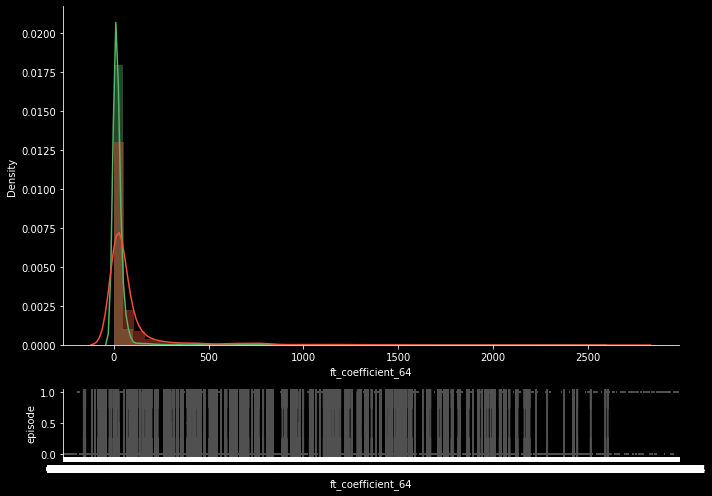

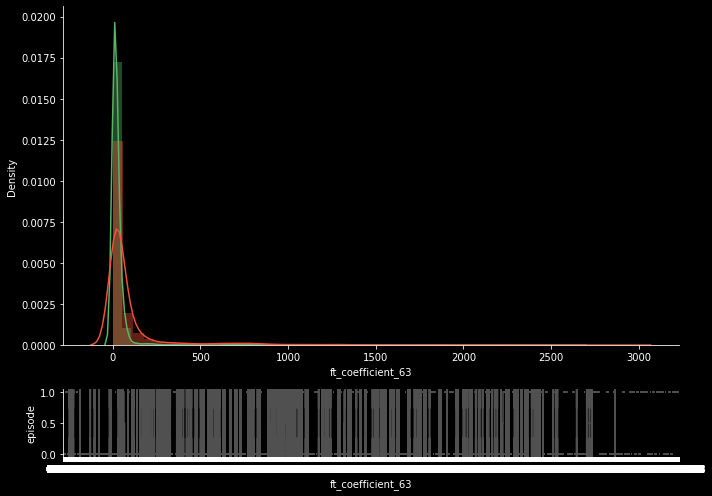

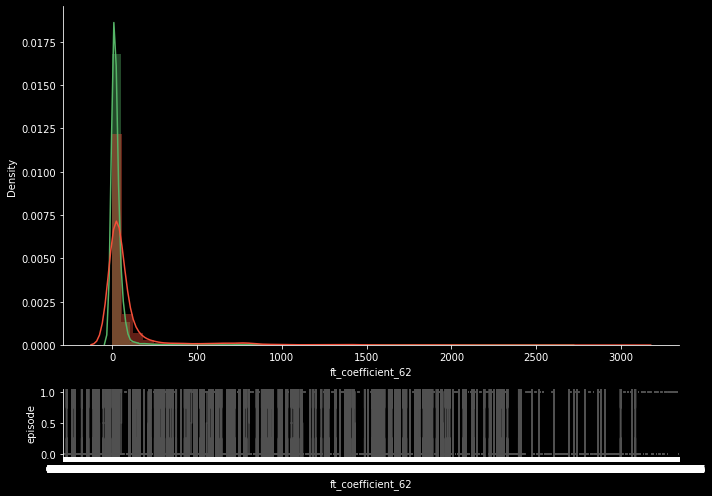

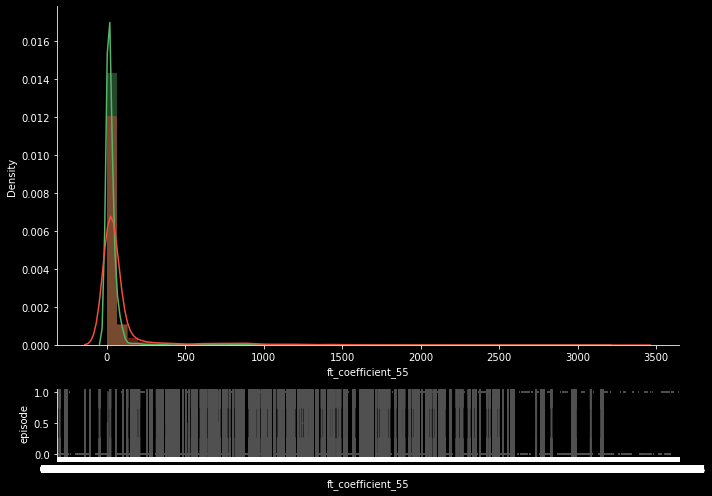

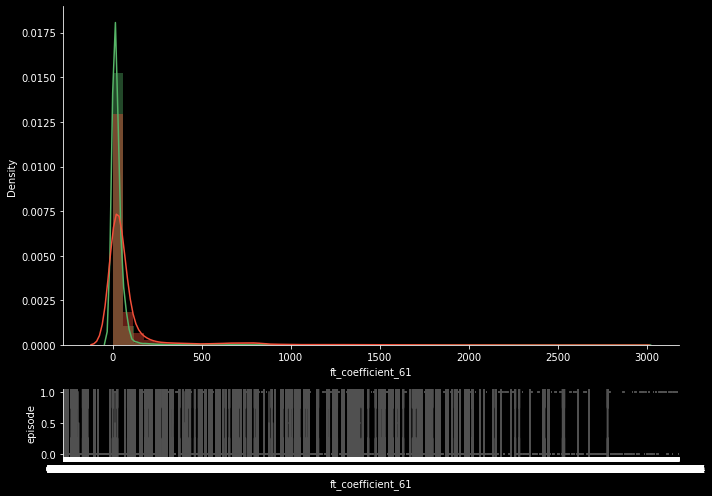

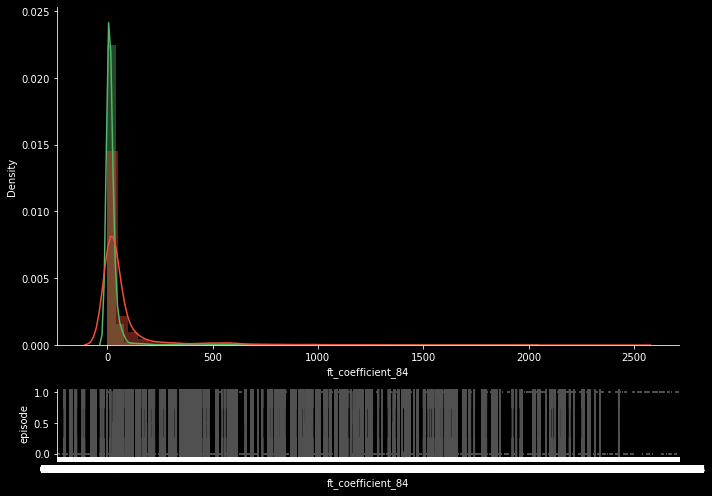

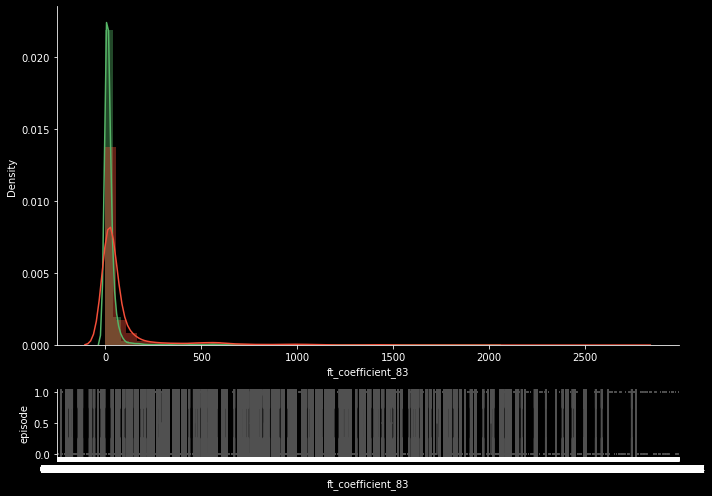

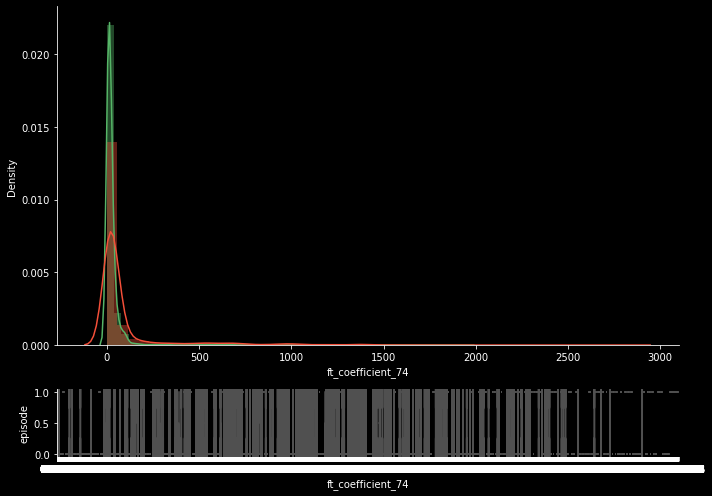

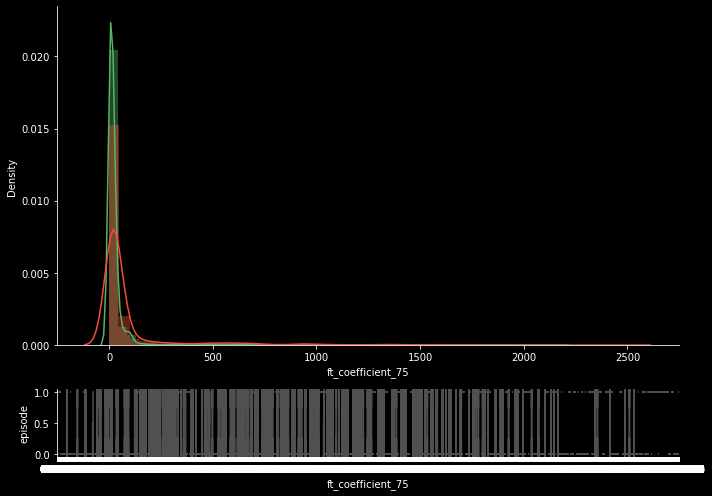

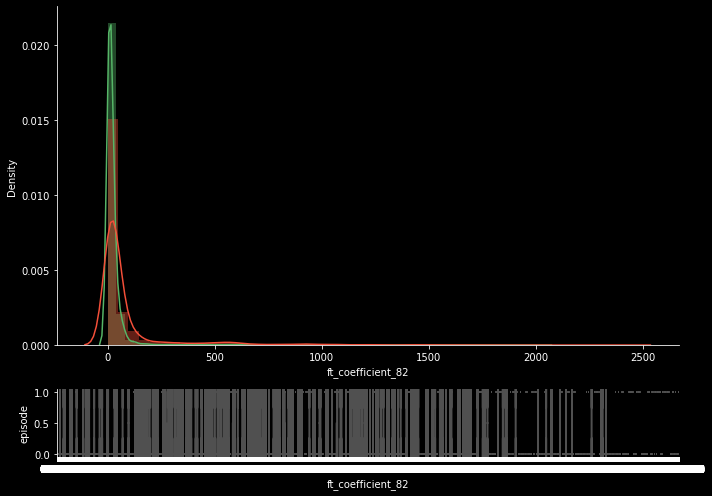

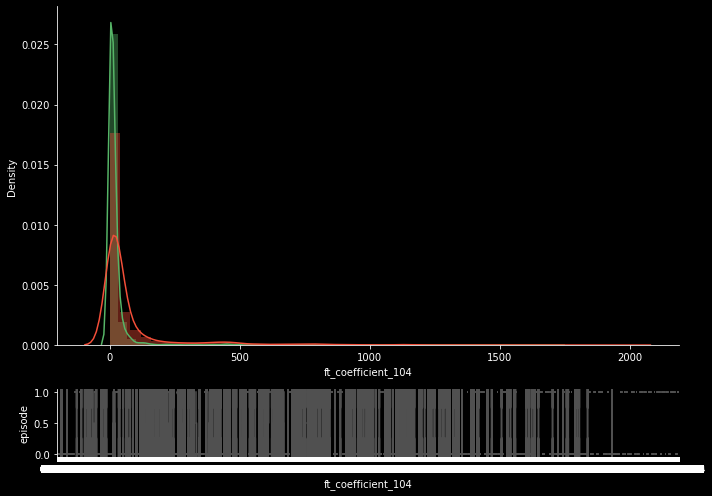

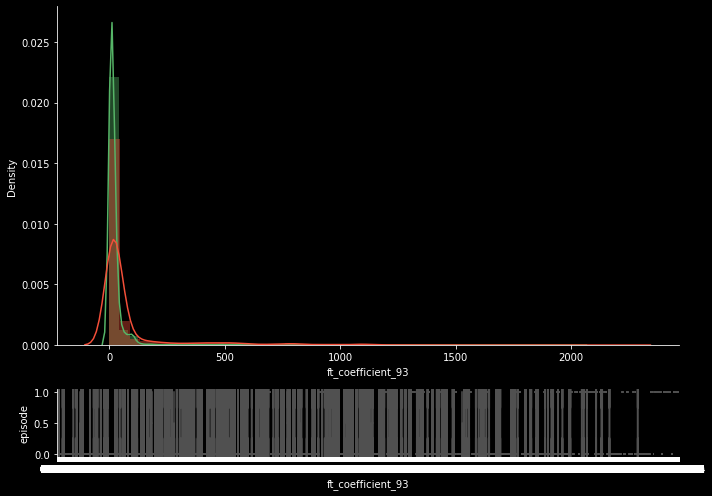

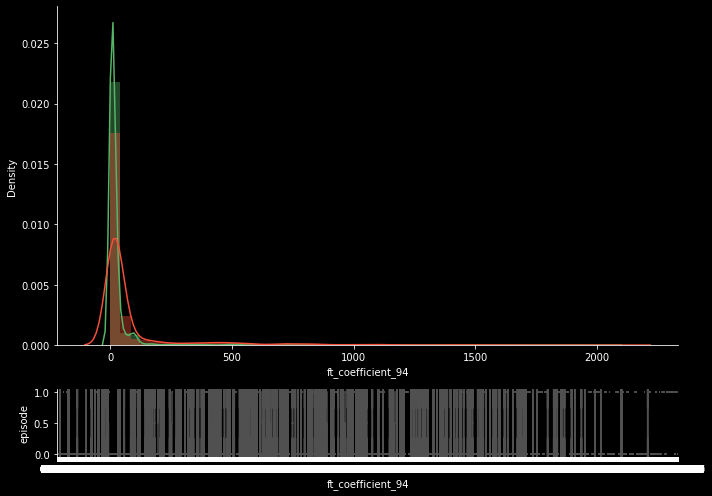

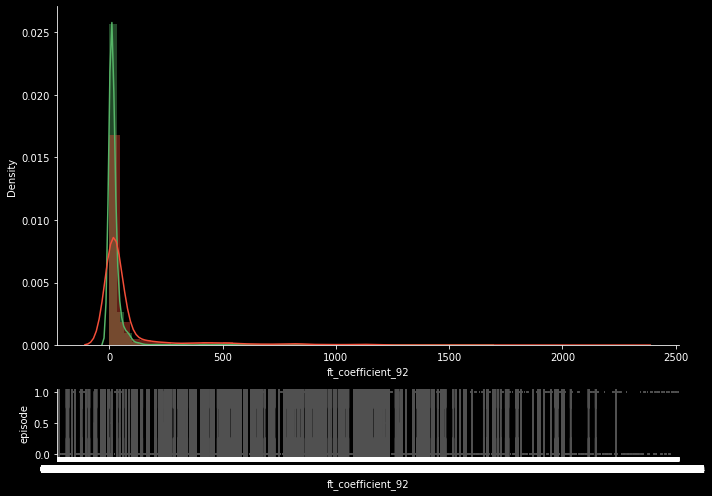

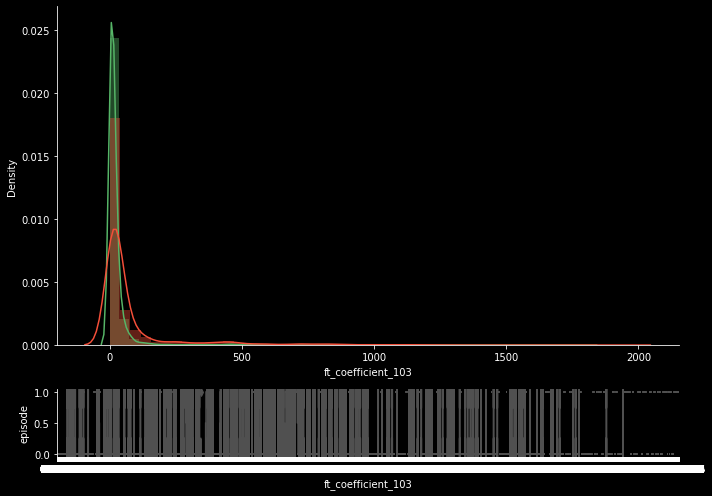

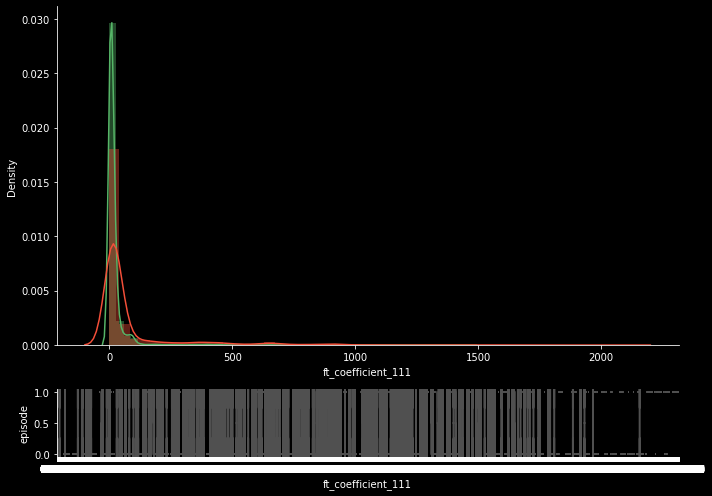

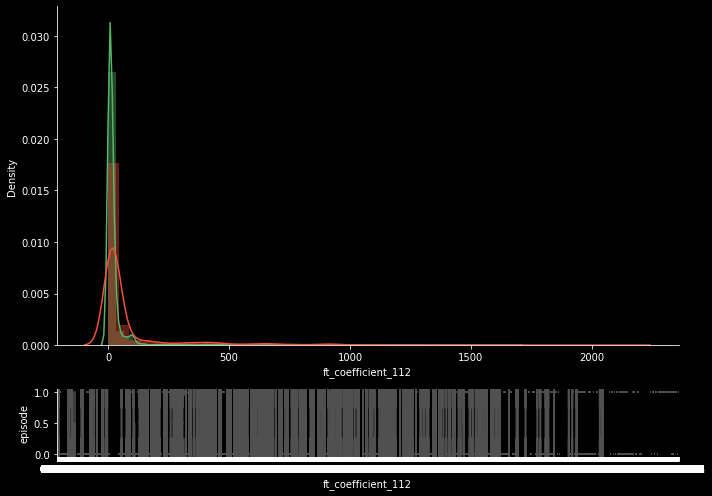

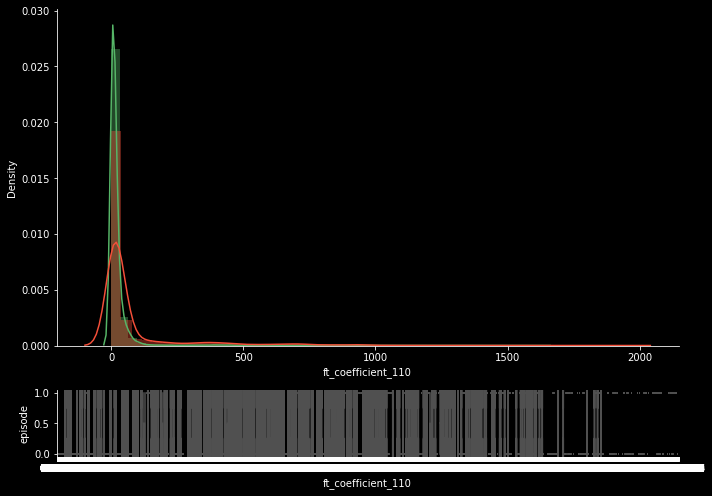

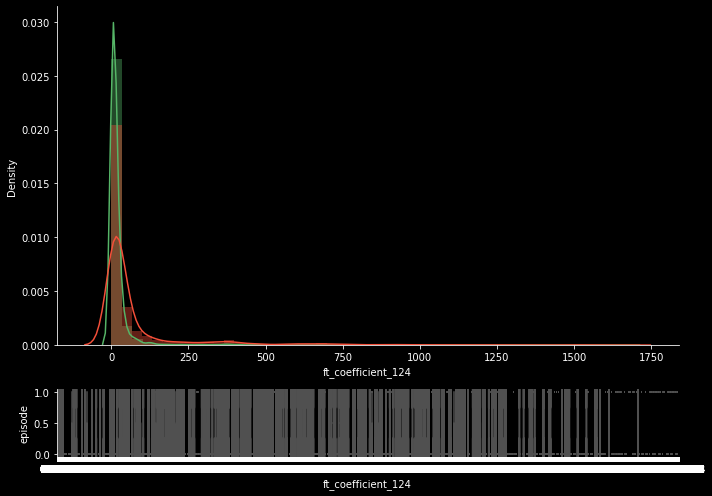

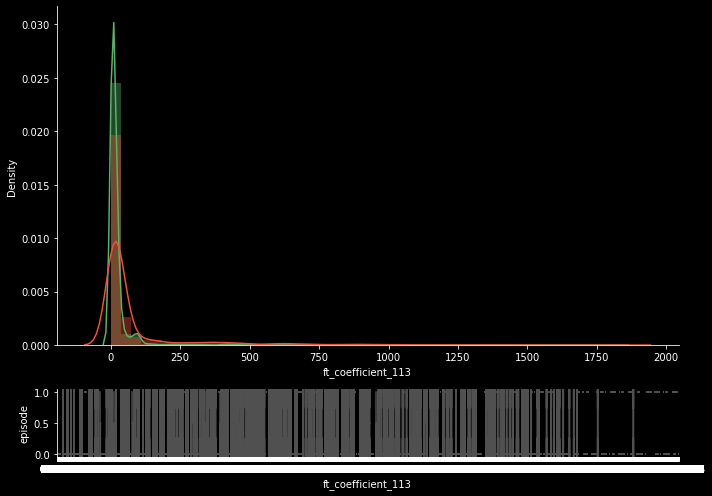

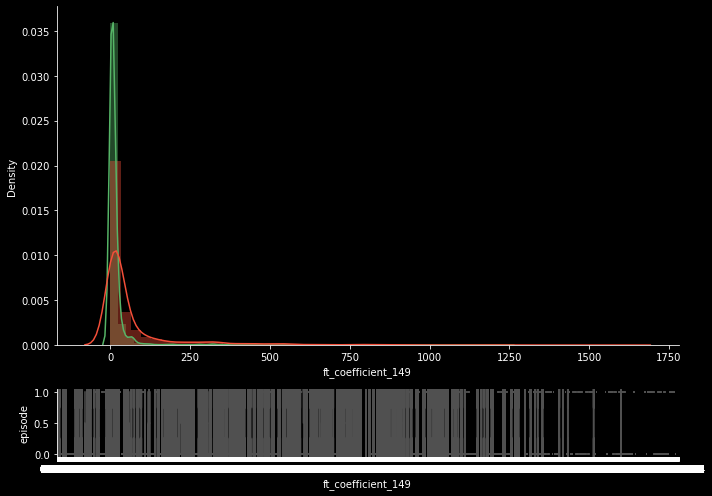

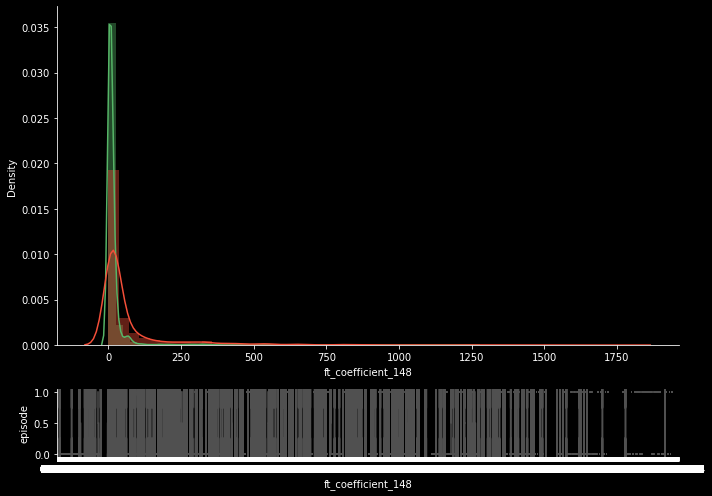

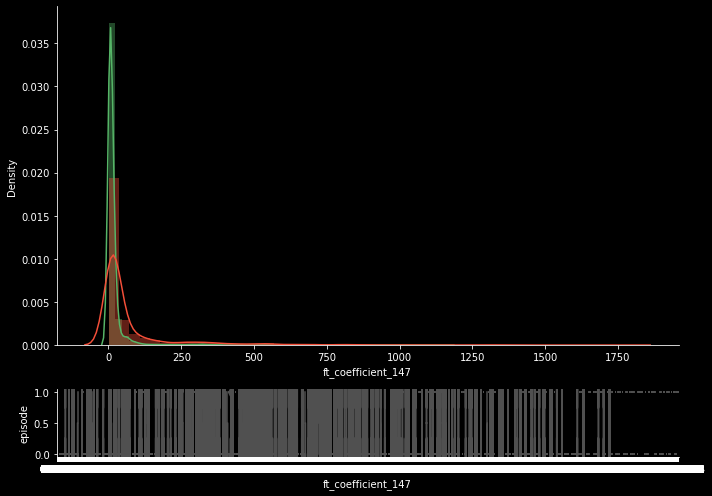

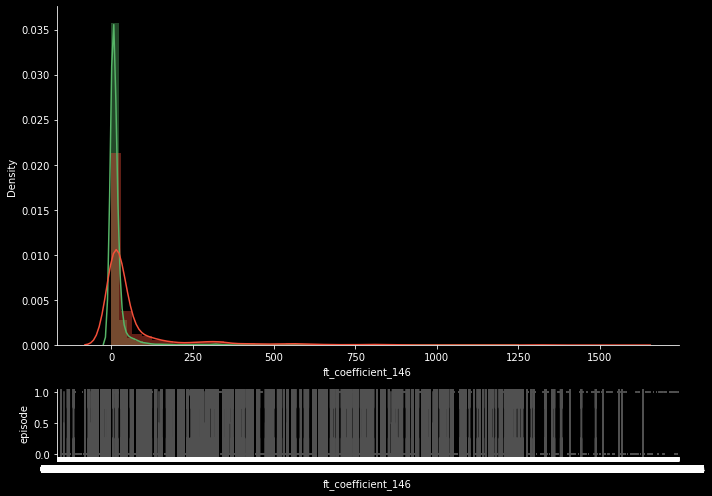

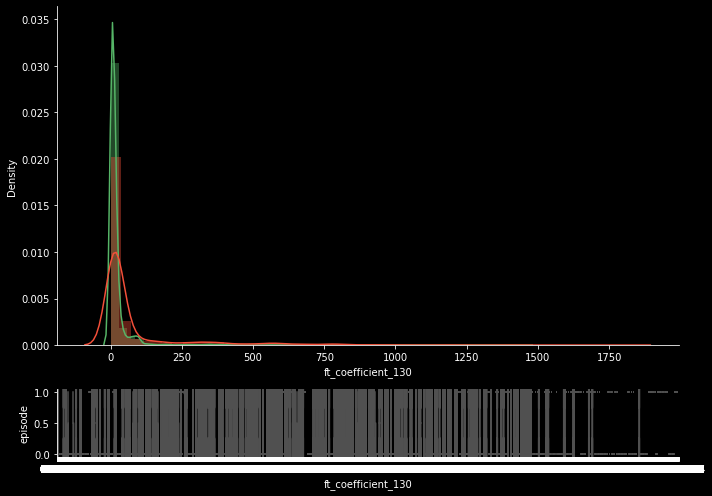

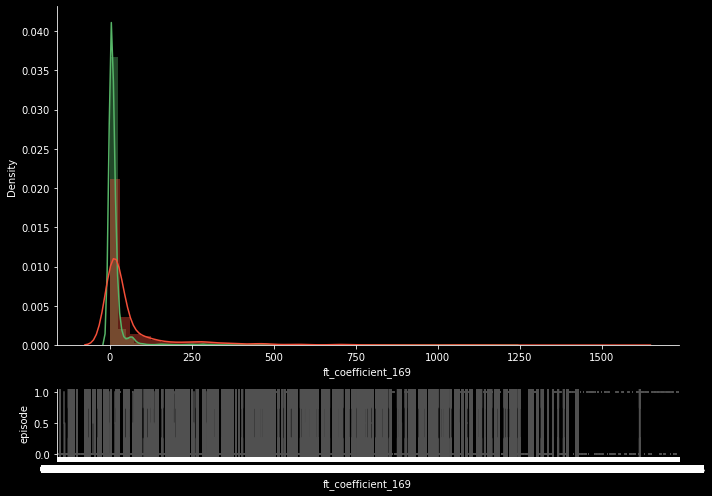

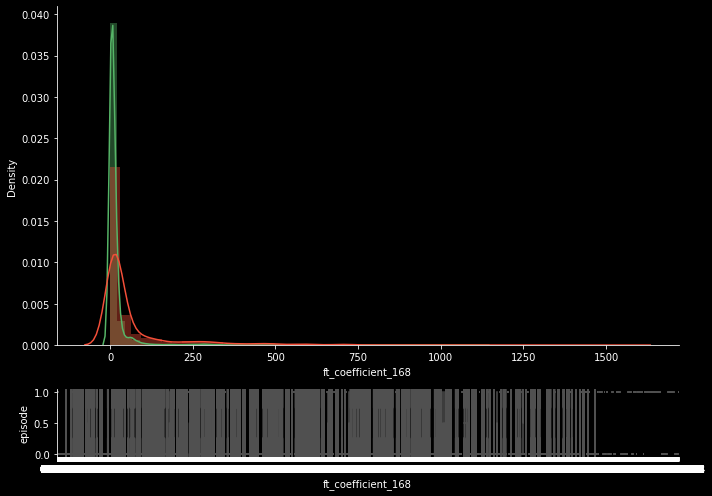

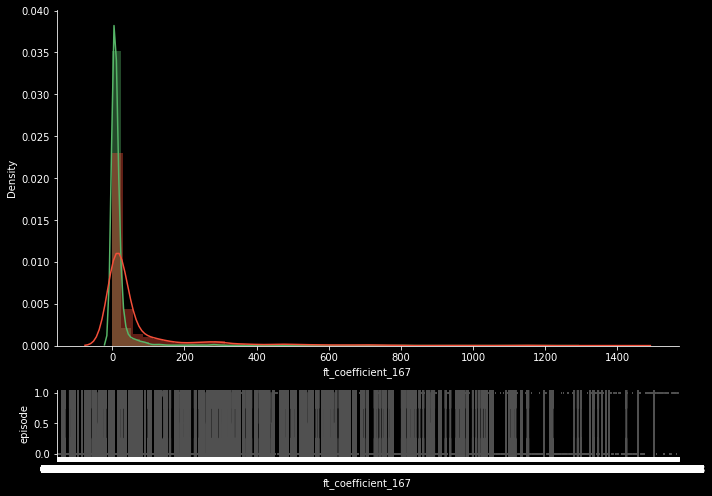

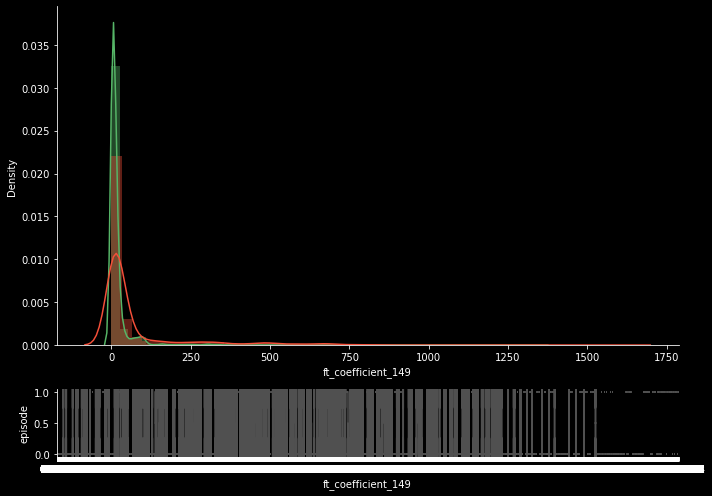

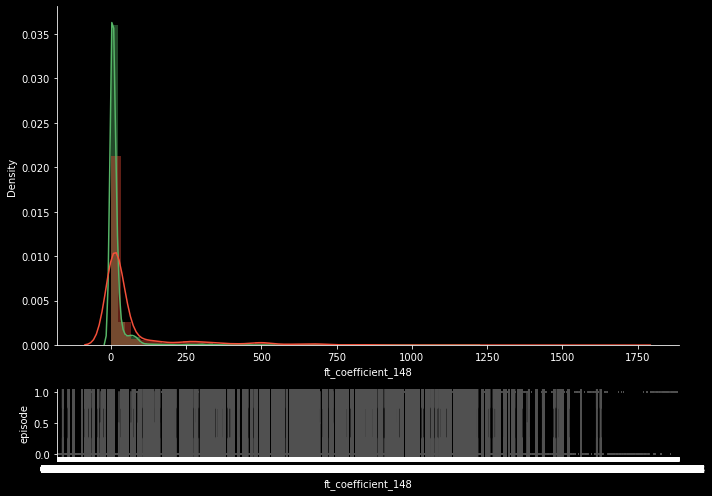

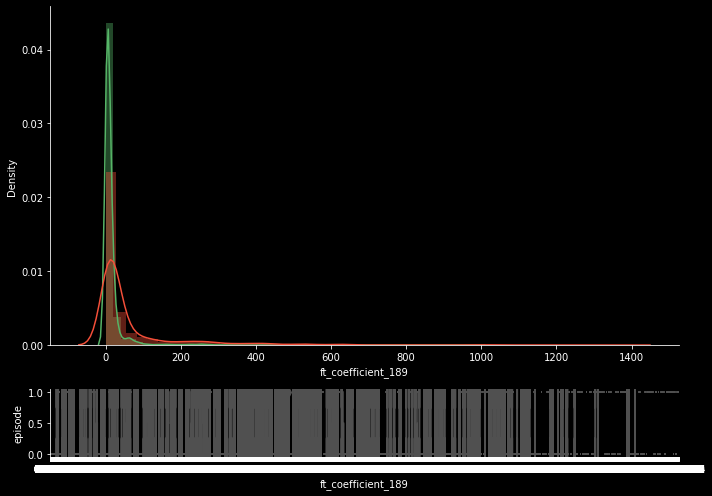

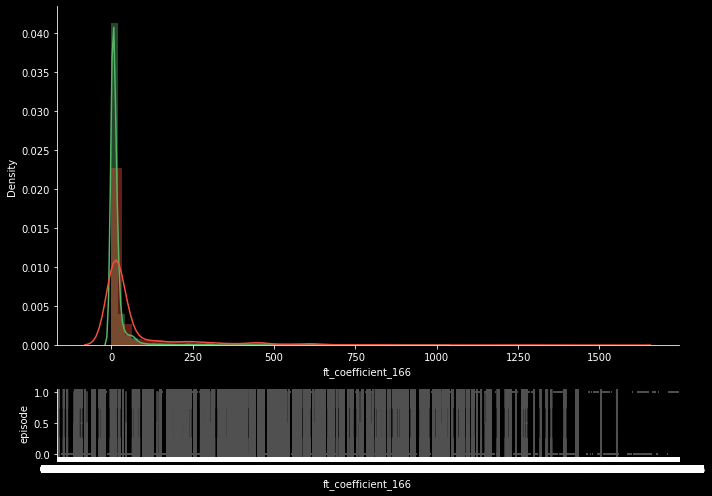

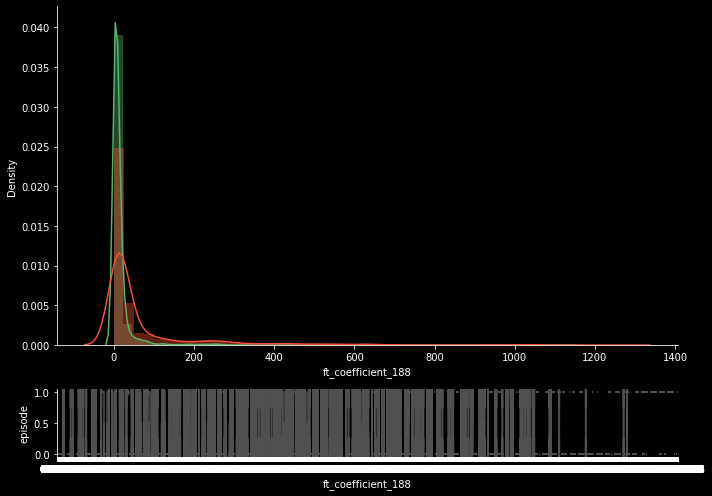

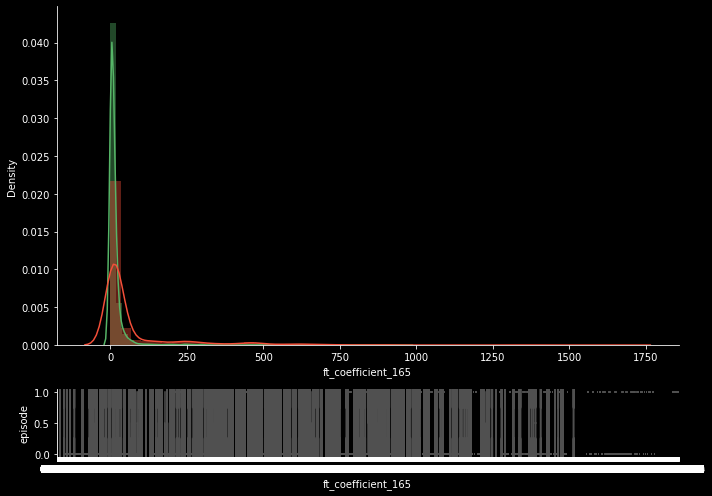

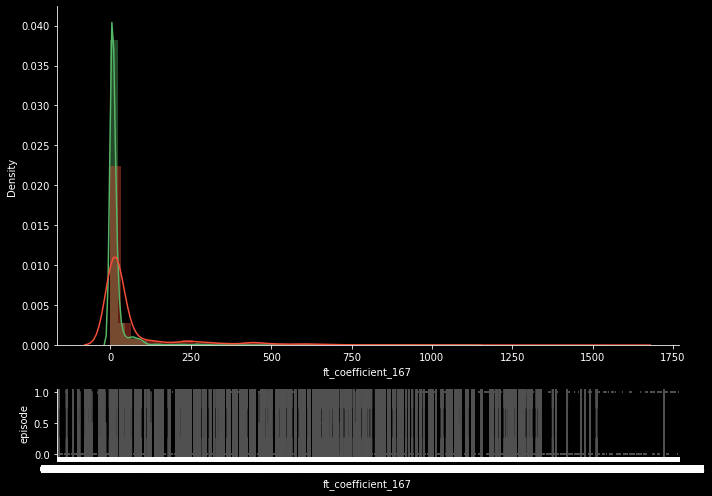

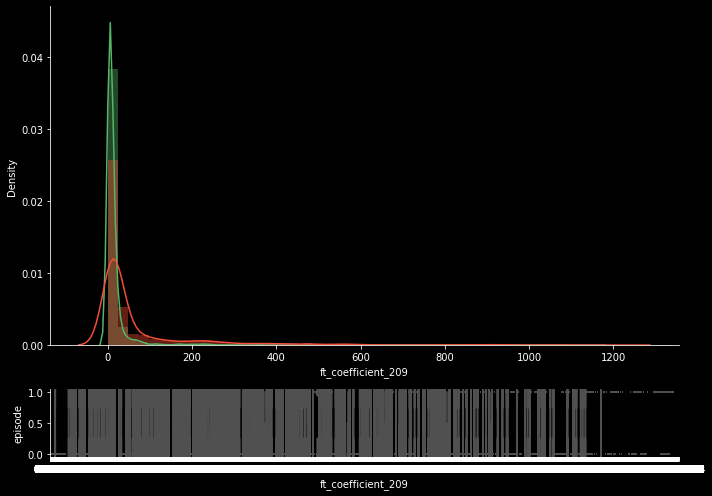

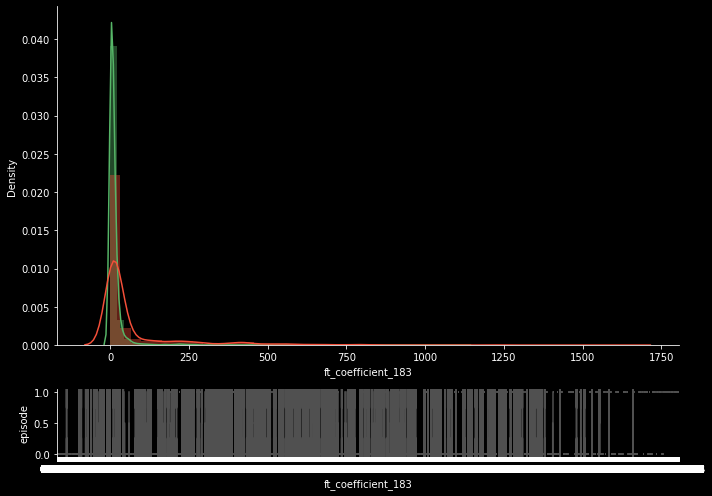

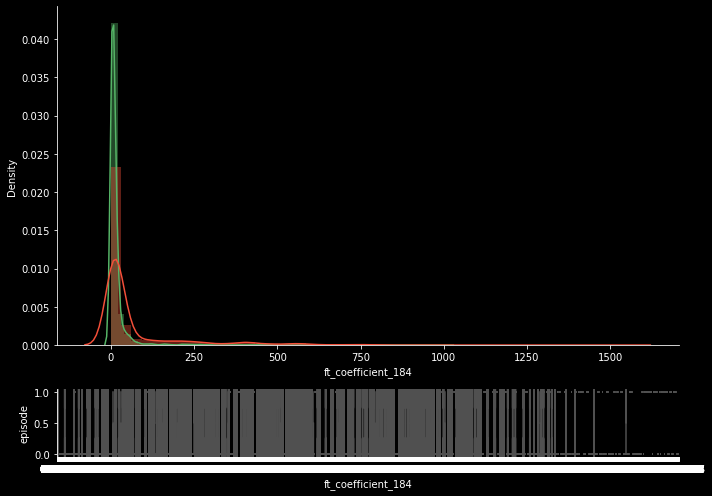

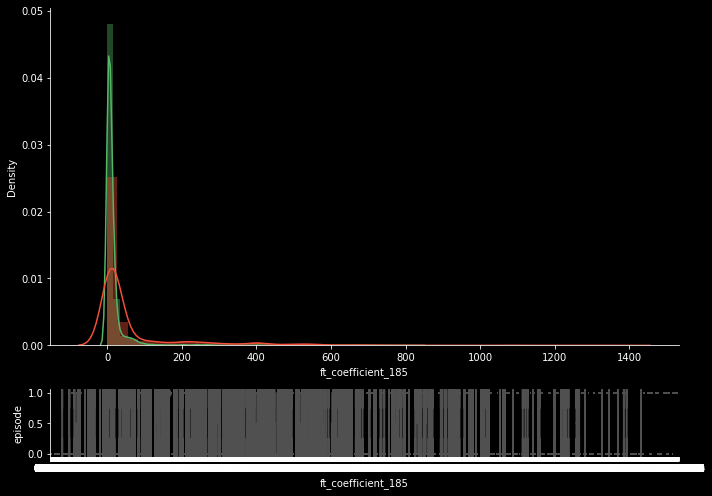

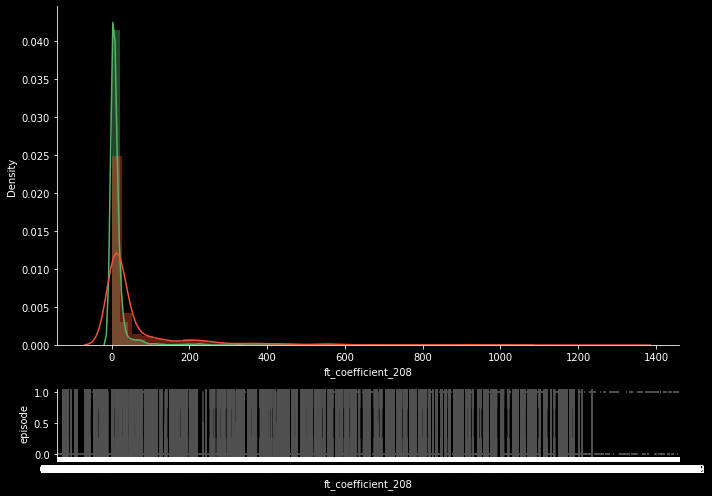

In [8]:
for segments_length_seconds, best_pbc_corrs_dict in best_pbc_corrs_by_dataset.items():
    file = f'ft_segments_{segments_length_seconds}s.csv'; print(file)

    dataset = dataset = pd.read_csv(f'{data_dir}\\{file}')

    dataset = dataset[dataset['episode'].isin(['N', 'VF'])]
    dataset.replace({'N': 0, 'VF': 1}, inplace = True)
    dataset['segment_fft'] = dataset['segment_fft'].apply(lambda seg_list: eval(seg_list))

    for top_ft_coeff in best_pbc_corrs_dict.keys():
        print(f'ft_coefficient_{top_ft_coeff}')

        dataset[f'ft_coefficient_{top_ft_coeff}'] = dataset['segment_fft'].apply(
            lambda ft_segment: ft_segment[top_ft_coeff]
        )

        distribution_histogram_box_plots(
                df = dataset,
                ft_feature_name = f'ft_coefficient_{top_ft_coeff}',
                class_feature_name = 'episode',
                classes = [0,1],
                classes_colors = ['g', 'r'],
                save_path = f'{plots_dir}\\segments_3s_ft_coeff_{top_ft_coeff}.pdf'
        )

In [ ]:
dataset[f'ft_coefficient_{top_ft_coeff}'] = dataset['segment_fft'].apply(
            lambda ft_segment: ft_segment[top_ft_coeff]
        )

